## Title
Author: John Mays
For: NYC Mayor's Office of Management and Budget
### Setup:

In [60]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [61]:
mpl.rcParams['figure.dpi'] = 150

### Importing Data:

In [62]:
prices = pd.concat([pd.read_excel('../data/2010_queens.xls', header=3),
                    pd.read_excel('../data/2010_bronx.xls', header=3),
                    pd.read_excel('../data/2010_brooklyn.xls', header=3),
                    pd.read_excel('../data/2010_manhattan.xls', header=3),
                    pd.read_excel('../data/2010_statenisland.xls', header=3)
                    ])

SAT_scores = pd.read_csv('../data/SAT__College_Board__2010_School_Level_Results_20231216.csv')

high_schools = pd.read_csv('../data/2014_-_2015_DOE_High_School_Directory_20231216.csv')

zip_boundaries = gpd.read_file('../data/Modified Zip Code Tabulation Areas (MODZCTA)_20231216.geojson')

In [63]:
residential_building_class_categories = [
   '01  ONE FAMILY HOMES                        ',
   '12  CONDOS - WALKUP APARTMENTS              ',
   '02  TWO FAMILY HOMES                        ',
   '03  THREE FAMILY HOMES                      ',
   '04  TAX CLASS 1 CONDOS                      ',
   '07  RENTALS - WALKUP APARTMENTS             ',
   '08  RENTALS - ELEVATOR APARTMENTS           ',
   '09  COOPS - WALKUP APARTMENTS               ',
   '10  COOPS - ELEVATOR APARTMENTS             ',
   '13  CONDOS - ELEVATOR APARTMENTS            ',
   '14  RENTALS - 4-10 UNIT                     ',
   '15  CONDOS - 2-10 UNIT RESIDENTIAL          ',
   '17  CONDOPS                                 ',
   '23  LOFT BUILDINGS                          ',
   '16  CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT ',
   '11A CONDO-RENTALS                           '
]

### Cleaning & Formatting Data:

In [64]:
prices = prices[prices['BUILDING CLASS CATEGORY'].isin(residential_building_class_categories)]
prices = prices[['ZIP CODE', 'SALE PRICE']]
prices = prices[prices['SALE PRICE']!=0]
# mean_prices = prices.groupby('ZIP CODE').agg(['mean', 'count'])
mean_prices = prices.groupby('ZIP CODE').mean()

In [65]:
high_schools.rename({'dbn': 'DBN', 'postcode': 'ZIP CODE'}, axis=1, inplace=True)
high_schools = high_schools[['DBN', 'ZIP CODE']]

In [66]:
zip_boundaries = zip_boundaries[['modzcta', 'geometry']]
zip_boundaries.rename({'modzcta': 'ZIP CODE'}, axis=1, inplace=True)
zip_boundaries['ZIP CODE'] = zip_boundaries['ZIP CODE'].astype('int64')

### Merging into one DataFrame indexed by ZIP Code:
#### Creating a DataFrame with Mean SAT Score by ZIP Code:

In [67]:
SAT_with_ZIP = SAT_scores.join(high_schools.set_index('DBN'), on='DBN', how='inner')
SAT_with_ZIP['Critical Reading Mean'] *= SAT_with_ZIP['Number of Test Takers']
SAT_with_ZIP['Mathematics Mean'] *= SAT_with_ZIP['Number of Test Takers']
SAT_with_ZIP['Writing Mean'] *= SAT_with_ZIP['Number of Test Takers']
SAT_with_ZIP = SAT_with_ZIP.dropna()
SAT_with_ZIP = SAT_with_ZIP[['Number of Test Takers', 'Critical Reading Mean',
                            'Mathematics Mean', 'Writing Mean', 'ZIP CODE']]
SAT_with_ZIP = SAT_with_ZIP.groupby('ZIP CODE').sum()
SAT_with_ZIP['Critical Reading Mean'] /= SAT_with_ZIP['Number of Test Takers']
SAT_with_ZIP['Mathematics Mean'] /= SAT_with_ZIP['Number of Test Takers']
SAT_with_ZIP['Writing Mean'] /= SAT_with_ZIP['Number of Test Takers']

In [68]:
SAT_with_ZIP.head()

,Number of Test Takers,Critical Reading Mean,Mathematics Mean,Writing Mean
ZIP CODE,,,,
10002,602.0,467.504983,481.842193,465.064784
10003,341.0,443.351906,448.680352,436.181818
10004,325.0,449.830769,469.676923,450.846154
10006,221.0,440.285068,478.221719,437.262443
10009,69.0,418.000000,431.000000,402.000000


#### Merging Zip Boundaries with Mean Housing Prices:

In [69]:
boundaries_with_prices = zip_boundaries.set_index('ZIP CODE').join(mean_prices, on='ZIP CODE', how='inner')

In [70]:
boundaries_with_prices.head()

,geometry,SALE PRICE
ZIP CODE,,
10001,"MULTIPOLYGON (((-73.98774 40.74407, -73.98819 ...",3.309001e+06
10002,"MULTIPOLYGON (((-73.99750 40.71407, -73.99709 ...",1.009097e+06
10003,"MULTIPOLYGON (((-73.98864 40.72293, -73.98876 ...",1.637252e+06
10026,"MULTIPOLYGON (((-73.96201 40.80551, -73.96007 ...",7.660633e+05
10004,"MULTIPOLYGON (((-74.00827 40.70772, -74.00937 ...",3.789727e+06


#### Total Merge:

### Analysis and Figures:

In [71]:
merged_df = boundaries_with_prices.copy()

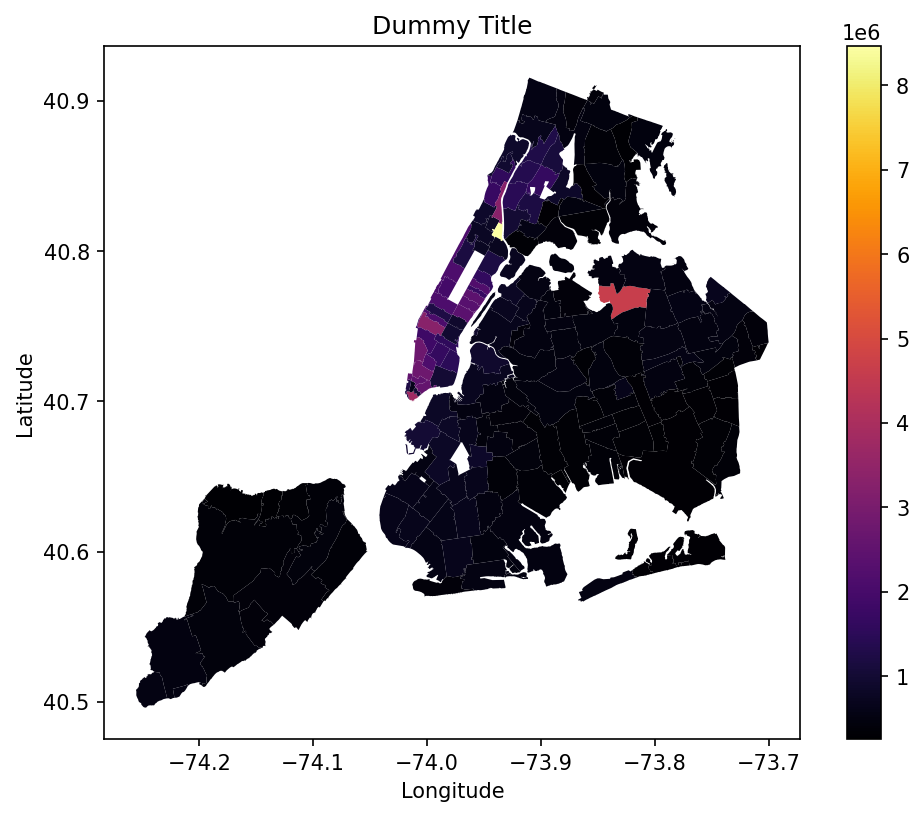

In [72]:
fig, ax = plt.subplots(1, figsize = (8, 6))
ax = merged_df.plot(column='SALE PRICE', cmap='inferno', ax=ax)
plt.colorbar(
    plt.cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(
        vmin=merged_df['SALE PRICE'].min(),
        vmax=merged_df['SALE PRICE'].max())),
        ax = ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Dummy Title')
plt.show();

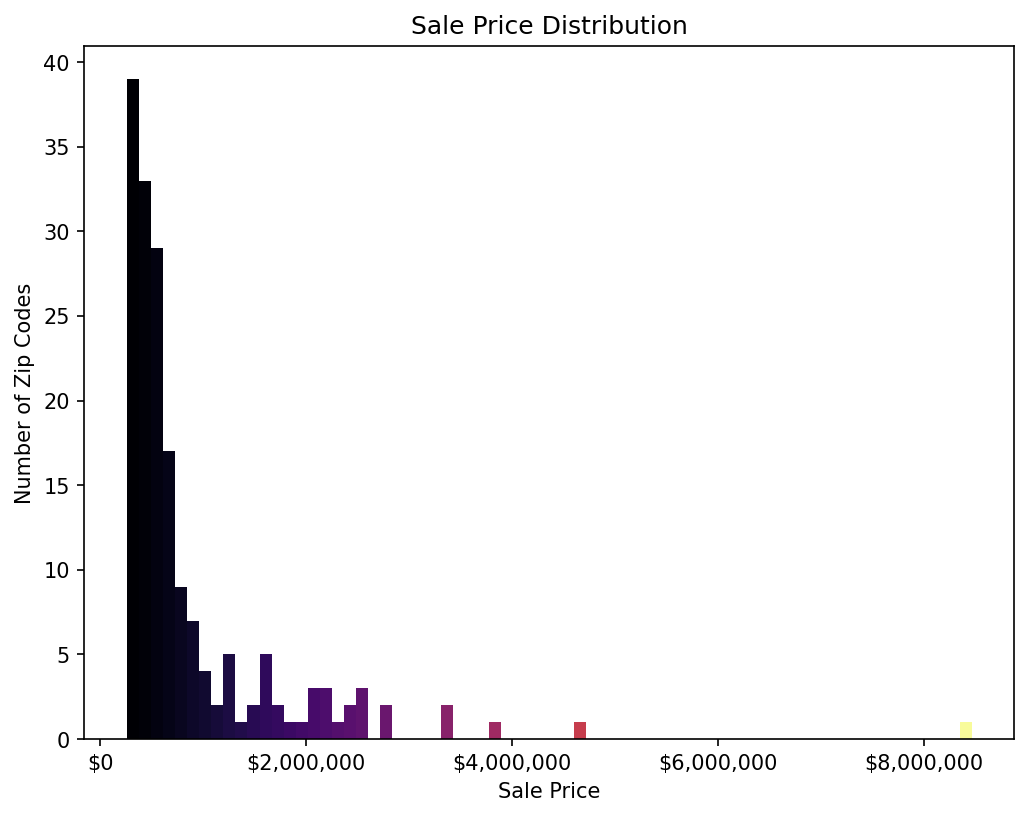

In [73]:
fig, ax = plt.subplots(1, figsize = (8, 6))
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
N, bins, patches = ax.hist(merged_df['SALE PRICE'], bins=70)

fracs = bins / bins.max()
norm = mpl.colors.Normalize(fracs.min(), fracs.max())
for frac, patch in zip(fracs, patches):
    color = plt.cm.inferno(norm(frac))
    patch.set_facecolor(color)

plt.ylabel('Number of Zip Codes')
plt.xlabel('Sale Price')
plt.title('Sale Price Distribution')
plt.show();